In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.mixture import GaussianMixture
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

data = pd.read_csv('comparaison.csv')
print(data)



   algorithm   node1   node2        time   nodes     memory
0        BFS  125730  125742   0.001895s      17    33.98KB
1        BFS  125730  398772    0.075107      71   890.98KB
2        BFS  125730  398800    0.077561      71   890.39KB
3        DFS  125730  125742    0.014924     688     1.73MB
4        DFS  125730  398772    0.250718     551    19.47MB
5        DFS  125730  398800    0.186598     624    19.47MB
6         ID  125730  125742    0.027737      36    47.18KB
7         ID  125730  398772    1.326473     180   304.27KB
8         ID  125730  398800    1.654286     188   310.68KB
9         A*  125730  125742    0.012794      18    84.48KB
10        A*  125730  398772    0.071280      79   594.59KB
11        A*  125730  398800    0.076445      83   494.06KB


In [32]:
df = pd.DataFrame(data)
df.columns = df.columns.str.strip()
if 'time' in df.columns:
    df['time'] = df['time'].astype(str).str.replace('s', '', regex=False).astype(float)
def _parse_memory(x):
    s = str(x).strip()
    if s.endswith('KB'):
        try:
            return float(s[:-2])
        except:
            return float('nan')
    if s.endswith('MB'):
        try:
            return float(s[:-2]) * 1024
        except:
            return float('nan')
    try:
        return float(s)
    except:
        return float('nan')

if 'memory' in df.columns:
    df['memory'] = df['memory'].apply(_parse_memory)

if 'algorithm' not in df.columns:
    raise ValueError("No 'algorithm' column found in the data")

agg = df.groupby('algorithm')[['time', 'memory']].mean().reset_index()
print('Aggregated algorithm metrics:')
print(agg)
features = ['time', 'memory']
X = agg[features].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
gmm_algo = GaussianMixture(n_components=4, random_state=42)
gmm_algo.fit(X_scaled)
agg['cluster'] = gmm_algo.predict(X_scaled)
df = df.merge(agg[['algorithm', 'cluster']], on='algorithm', how='left')

print('Aggregated with cluster labels:')
print(agg)
print(df.head())

Aggregated algorithm metrics:
  algorithm      time        memory
0        A*  0.053506    391.043333
1       BFS  0.051521    605.116667
2       DFS  0.150747  13882.026667
3        ID  1.002832    220.710000
Aggregated with cluster labels:
  algorithm      time        memory  cluster
0        A*  0.053506    391.043333        3
1       BFS  0.051521    605.116667        0
2       DFS  0.150747  13882.026667        2
3        ID  1.002832    220.710000        1
  algorithm   node1   node2      time  nodes    memory  cluster
0       BFS  125730  125742  0.001895     17     33.98        0
1       BFS  125730  398772  0.075107     71    890.98        0
2       BFS  125730  398800  0.077561     71    890.39        0
3       DFS  125730  125742  0.014924    688   1771.52        2
4       DFS  125730  398772  0.250718    551  19937.28        2


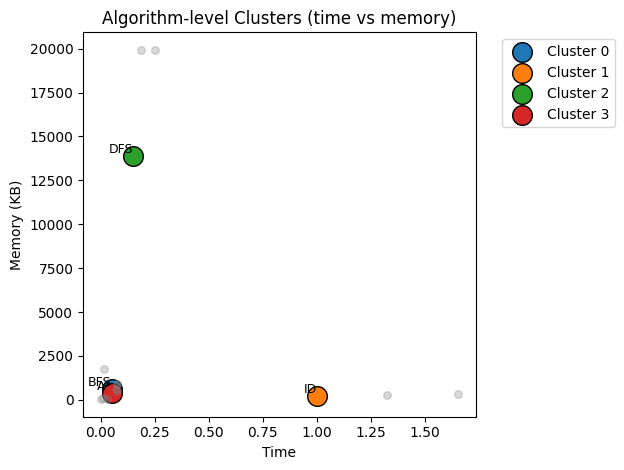

In [33]:
agg_sorted = agg.sort_values('cluster')
colors = plt.cm.tab10.colors
for i, row in agg_sorted.iterrows():
    cl = row['cluster']
    plt.scatter(row['time'], row['memory'], s=200, color=colors[int(cl) % len(colors)], edgecolor='k', label=f'Cluster {cl}'
)
    plt.text(row['time'], row['memory'], row['algorithm'], fontsize=9, va='bottom', ha='right')

if 'time' in df.columns and 'memory' in df.columns:
    plt.scatter(df['time'], df['memory'], s=30, color='gray', alpha=0.3, label='_nolegend_')

plt.xlabel('Time')
plt.ylabel('Memory (KB)')
plt.title('Algorithm-level Clusters (time vs memory)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()